Lettura periodo


In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import math
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import numpy as np
import datetime
from os import listdir
from os.path import isfile, join

from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages

percorso = 'D:/Università/Tirocinio/Analisi Dati/Studio Dati/'
cartella = 'risultati_terremoto/'
# percorso = 'D:/Tirocinio/programmi/Studio Dati/'

coms = pd.Series(pd.read_csv('D:/Università/Tirocinio/Analisi Dati/Grezzo Niki/sezione2comuneDEF.csv').comune.unique(),
                 name='Comune')
# coms = pd.Series(pd.read_csv('D:/Tirocinio/programmi/Grezzo Niki/sezione2comuneDEF.csv').comune.unique(), name= 'Comune')
crateri = pd.read_csv('D:/Università/Tirocinio/Analisi Dati/Studio Dati/crateriCentroIT.csv', sep=';').merge(coms, how='outer').drop(columns='Provincia')
# crateri = pd.read_csv('D:/Tirocinio/programmi/Studio Dati/crateriCentroIT.csv', sep=';').merge(coms, how='outer').drop(columns='Provincia')
crateri['Cratere Centro Italia 2016'].fillna('0', inplace=True)
onlyfiles = [f for f in listdir(f'{percorso}/risultati_terremoto/') if
             isfile(join(f'{percorso}/risultati_terremoto/', f))]
files = [f for f in
         listdir(f'D:/Università/Tirocinio/Analisi Dati/Selini/istat/BilancioDemografico-SingolaArea-Comuni_Ancona/') if
         isfile(
             join(f'D:/Università/Tirocinio/Analisi Dati/Selini/istat/BilancioDemografico-SingolaArea-Comuni_Ancona/',
                  f))]

inizio1 = '20150801'
fine1 = '20151231'
inizio2 = '20160801'
fine2 = '20161231'

def periodi(inizio1,fine1,inizio2,fine2):
    inizio = [pd.to_datetime(inizio1, format='%Y%m%d'), pd.to_datetime(inizio2, format='%Y%m%d')]
    # Mancano 4 ore nel giorno 2016-08-16
    fine = [pd.to_datetime(fine1, format='%Y%m%d'), pd.to_datetime(fine2, format='%Y%m%d')]
    #comune = 'Macerata'
    for years in range(2):
        ini = inizio[years]
        fin = fine[years]
        files = []
        for i in onlyfiles:
            data = pd.to_datetime(i.split('_')[1])
            if data >= ini and data <= fin:
                files.append(i)



        gg = pd.read_csv(f'{percorso}{cartella}{files[0]}', header=None)
        gg = gg.drop_duplicates(keep='last', ignore_index=True)
        db = gg.groupby(0).mean().reset_index()
        db.rename(columns={0: 'Comune', 1: f'{gg.iloc[0, 2][6:8]}_{gg.iloc[0, 2][4:6]}_{gg.iloc[0, 2][0:4]}'}, inplace=True)
        for i in range(1, len(files)):
            gg = pd.read_csv(f'{percorso}{cartella}{files[i]}', header=None)
            gg = gg.drop_duplicates(keep='first', ignore_index=True)
            ciclo = gg.groupby(0).mean().reset_index()
            ciclo.rename(columns={0: 'Comune', 1: f'{gg.iloc[0, 2][6:8]}_{gg.iloc[0, 2][4:6]}_{gg.iloc[0, 2][0:4]}'}, inplace=True)

            db = pd.merge(db, ciclo)
        df = pd.merge(db, crateri)
        cols = df.columns.tolist()
        cols = cols[:1] + cols[-1:] + cols[1:-1]
        checked = cols[:3]
        next = int(cols[2][:2])
        for i in range(3, len(cols)):
            now = next
            next = int(cols[i][:2])
            if next == now + 1:
                checked.append(cols[i])
            elif now in [28, 30, 31] and next == 1:
                checked.append(cols[i])
            else:
                print(f'now = {cols[i - 1]} -->{now}\n next = {cols[i]}--> {next}')
                break
        df = df[checked]
        if years == 0:
            qu = df
        else:
            se = df
    return [qu,se]
#media settimanale
# ms = qu.transpose()
# comu = ms.iloc[0, :]
# ms.drop(index=['Comune', 'Cratere Centro Italia 2016'], inplace=True)
# first_day = ms.index[0][:5]
# ms.set_index(np.arange(ms.shape[0])//7,drop = True,inplace= True)
# ms = ms.iloc[:,:].astype(float)
# ms = ms.groupby(ms.index).mean().transpose()
#ms.set_index(comu,drop= True)
# SOTTRAZIONE 2015 AL 2016
# comu = [se.iloc[:, 0]]
def sottrazione(qu, se, inizio1):
    di = se.drop(columns=['Cratere Centro Italia 2016', 'Comune'])
    # di = di.astype(float)
    starting_day = f'{qu.columns[2][:5]}_{pd.to_datetime(inizio1, format="%Y%m%d").year}'
    ds = qu.drop(columns=['Cratere Centro Italia 2016', 'Comune'])
    ok = False
    cols = []
    for i in di.columns:
        if i[:5] == starting_day[:5]:
            ok = True
        if ok: cols.append(i)
    di = di[cols]
    di = di.iloc[:, [x for x in range(min(di.shape[1], ds.shape[1]))]]

    di = di.iloc[:, :].astype(float)
    ds = ds.iloc[:, :].astype(float)
    cols = []
    for i in di.columns:
        cols.append(i[:5])
    di.columns = cols
    ds.columns = cols

    di = di - ds
    di = di.set_index(se.Comune, drop=True)
    di.reset_index(inplace=True)
    return di

def sottrazione_giorno_settimana(qu,se):
    q = qu.copy()


    s = se.copy()
    q = q.iloc[:, 4:]
    s = s.iloc[:, 2:-2]
    cols = []
    for x in s.columns:
        cols.append(x[:5])
    q.columns = cols
    s.columns = cols
    t = s - q
    t = t.set_index(se.Comune, drop=True)
    t.reset_index(inplace=True)
    return t

def comuni_gravi(di, crateri):
    df = di.copy()
    cols = []
    appunti = open(f'{percorso}/appunti.txt', mode='r')
    sfig = appunti.readline().split(', ')
    appunti.close()
    crateri = crateri.rename(columns={'Cratere Centro Italia 2016': 'Terremotata'})
    for i in range(len(sfig)):
        plm = sfig[i].split(' ')[:-1]
        sfig[i] = ' '.join(plm)
    for i in sfig:
        crateri.loc[crateri.Comune == i, 'Terremotata'] = 2
    df = df.merge(crateri)
    cols = df.columns.tolist()
    cols = [cols[0]] + [cols[-1]] + cols[1:-1]
    df = df[cols]
    return df


anni = periodi(inizio1, fine1, inizio2,fine2)
qu =anni[0]
se = anni[1]
di = sottrazione_giorno_settimana(qu, se)
# di = sottrazione(qu, se, inizio1)
df = comuni_gravi(di,crateri)
gravi = df.loc[df.Terremotata == 2]
Files = []
for i in gravi.Comune:
    for x in files:
        if i in x:
            Files.append(x)

BilancioDemografico-SingolaArea-Comune_057001-Accumoli.csv: (['01_08_2016', '30_10_2016'], ['655', '639'])


<Figure size 432x288 with 0 Axes>

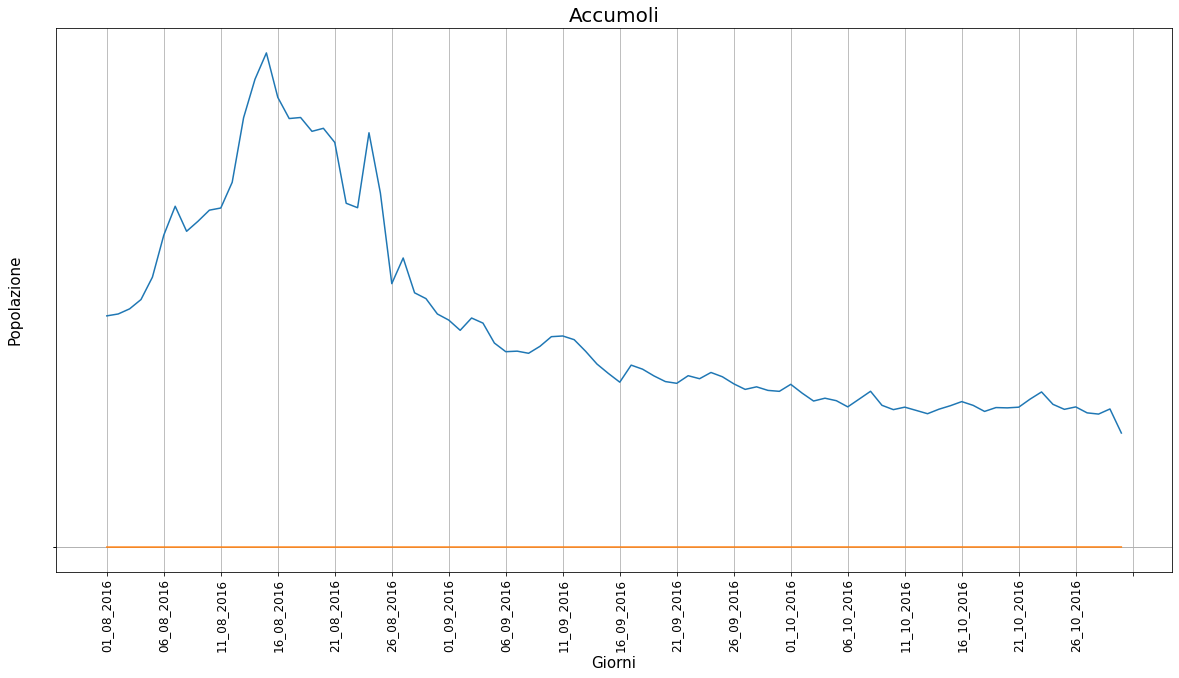

<Figure size 432x288 with 0 Axes>

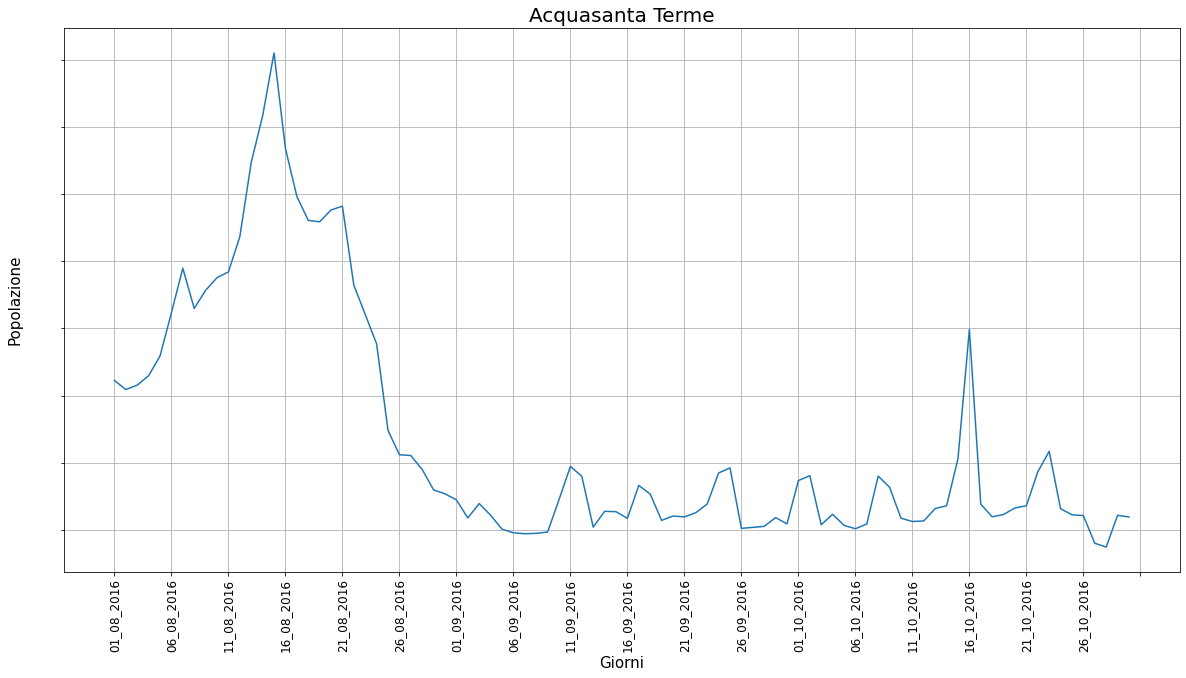

BilancioDemografico-SingolaArea-Comune_057002-Amatrice.csv: (['01_08_2016', '30_10_2016'], ['2639', '2503'])


<Figure size 432x288 with 0 Axes>

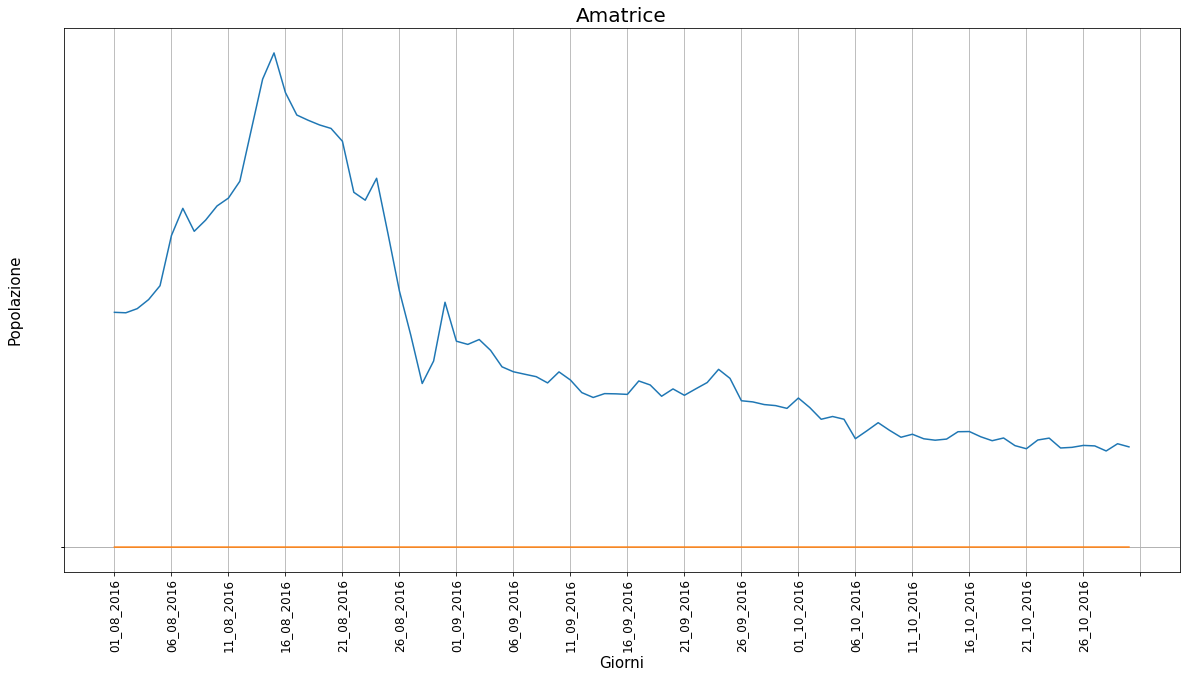

<Figure size 432x288 with 0 Axes>

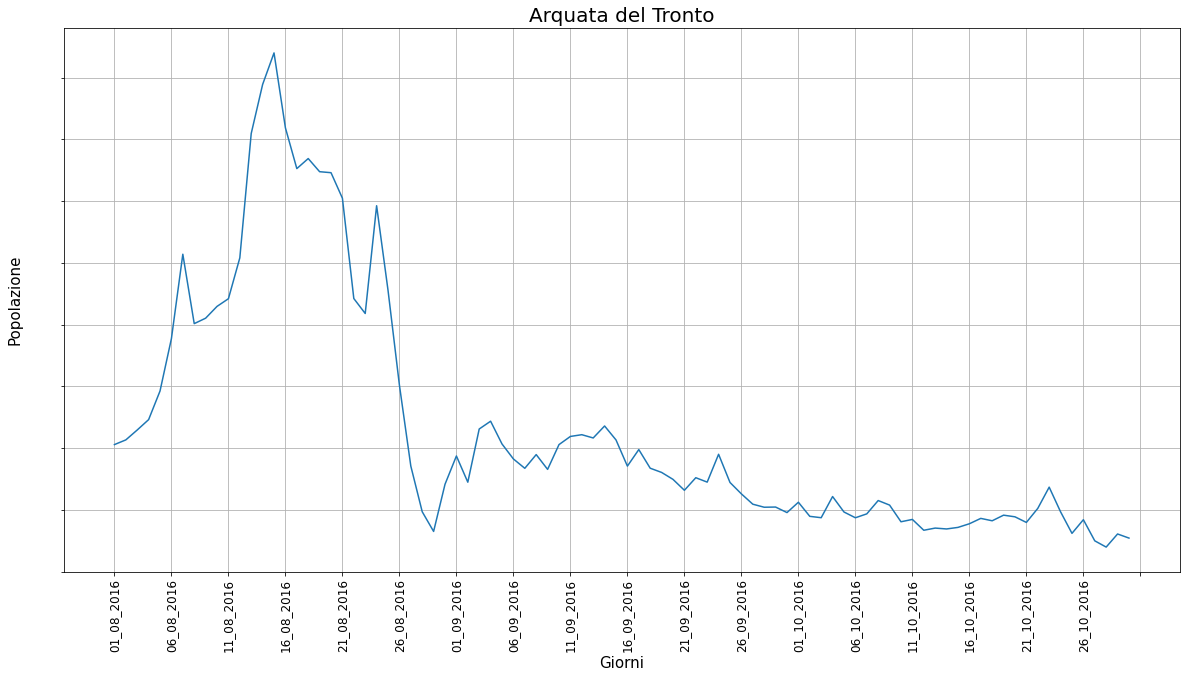

BilancioDemografico-SingolaArea-Comune_066016-Campotosto.csv: (['01_08_2016', '30_10_2016'], ['543', '551'])


<Figure size 432x288 with 0 Axes>

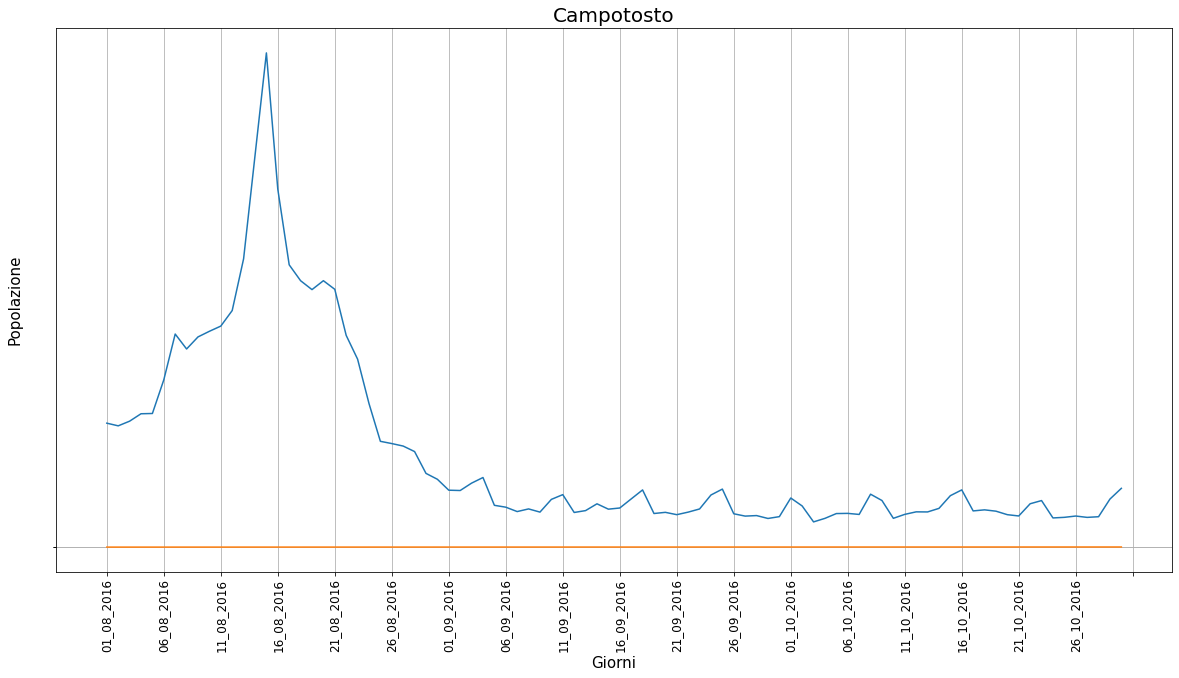

BilancioDemografico-SingolaArea-Comune_066021-Capitignano.csv: (['01_08_2016', '30_10_2016'], ['670', '689'])


<Figure size 432x288 with 0 Axes>

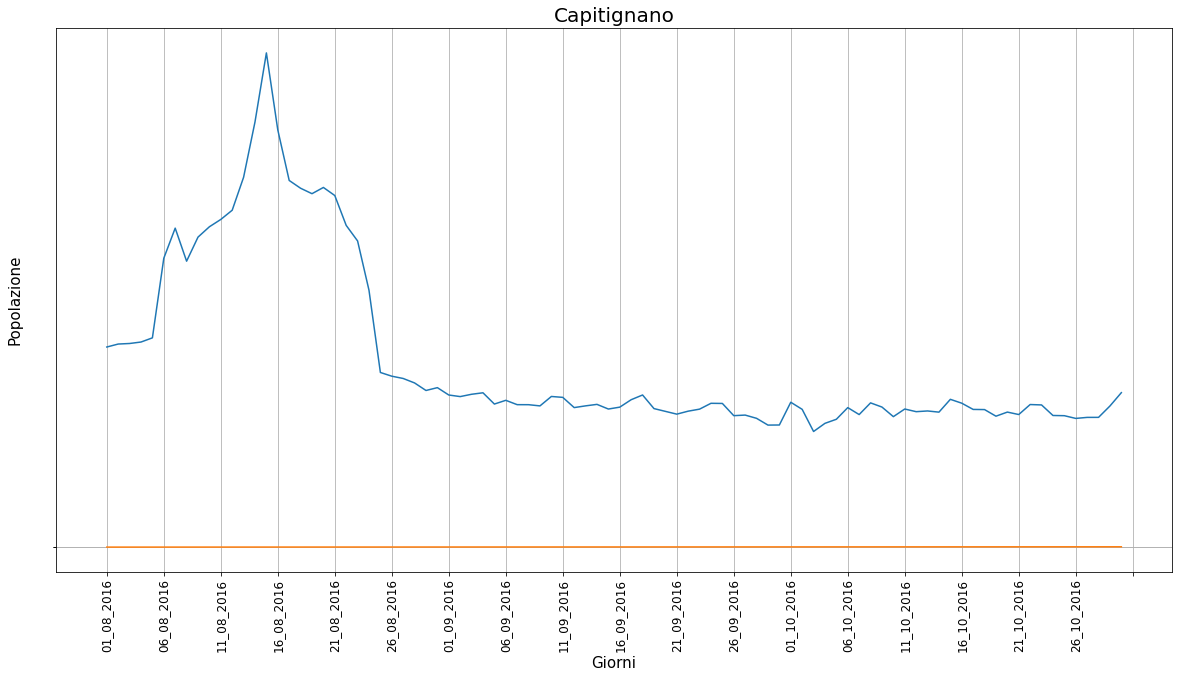

BilancioDemografico-SingolaArea-Comune_012038-Casciago.csv: (['01_08_2016', '30_10_2016'], ['3786', '3783'])


<Figure size 432x288 with 0 Axes>

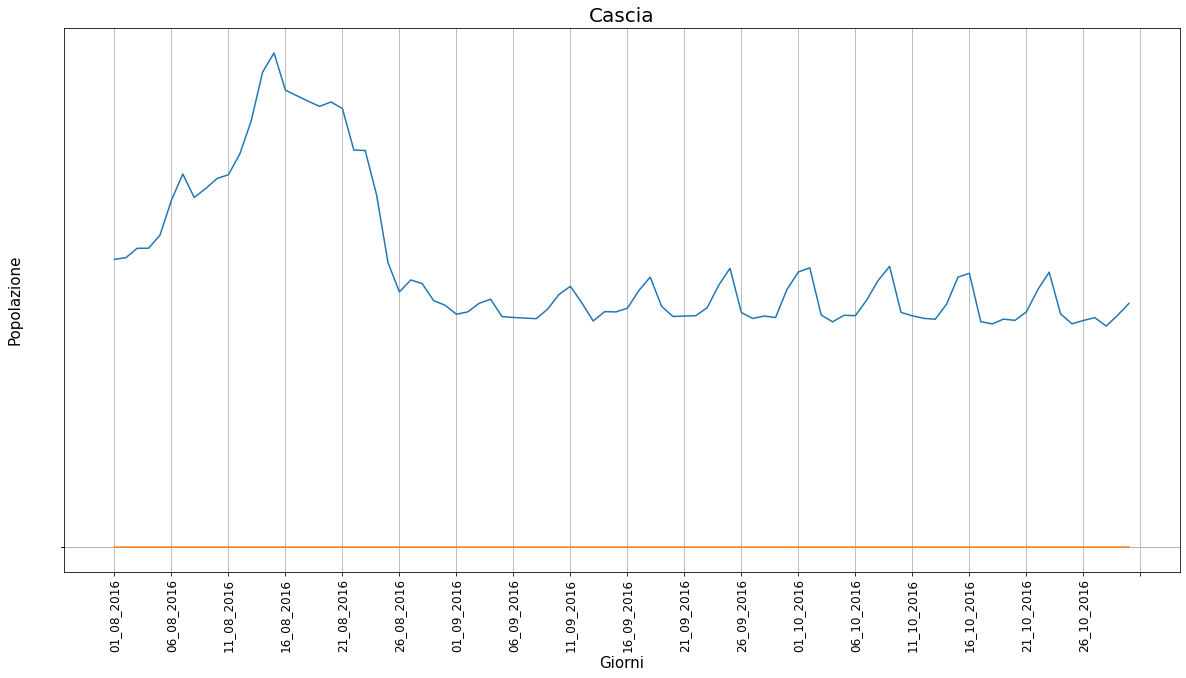

BilancioDemografico-SingolaArea-Comune_057017-Cittareale.csv: (['01_08_2016', '30_10_2016'], ['486', '473'])


<Figure size 432x288 with 0 Axes>

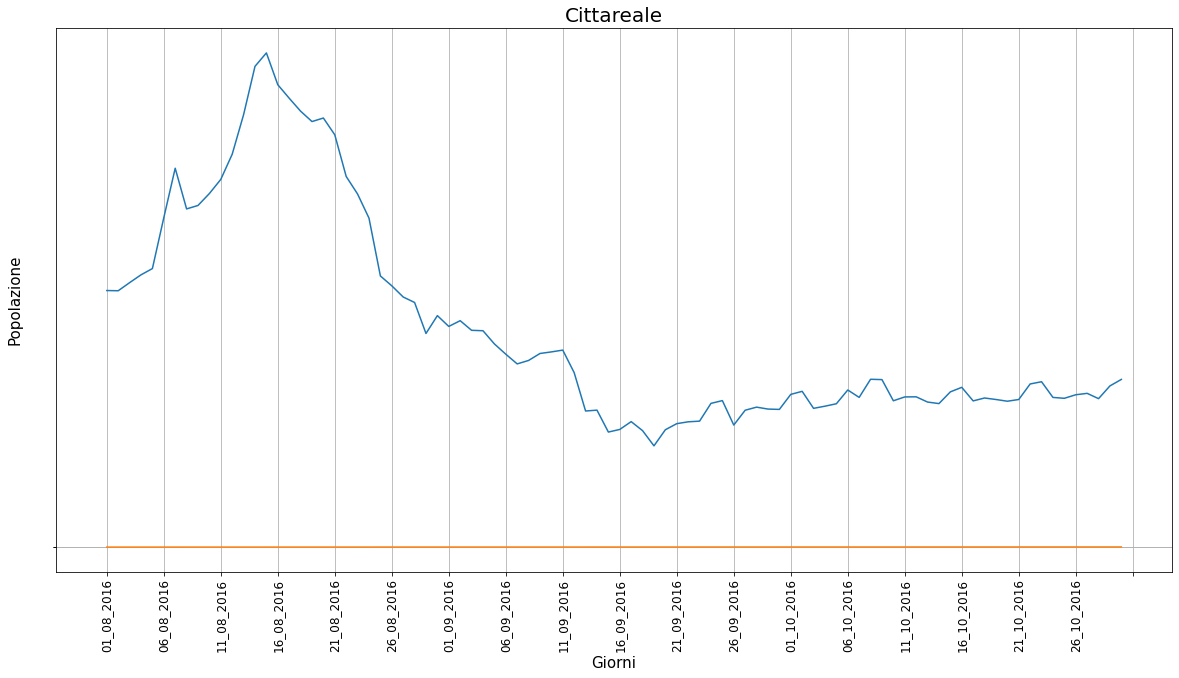

BilancioDemografico-SingolaArea-Comune_109015-Montefortino.csv: (['01_08_2016', '30_10_2016'], ['1184', '1149'])


<Figure size 432x288 with 0 Axes>

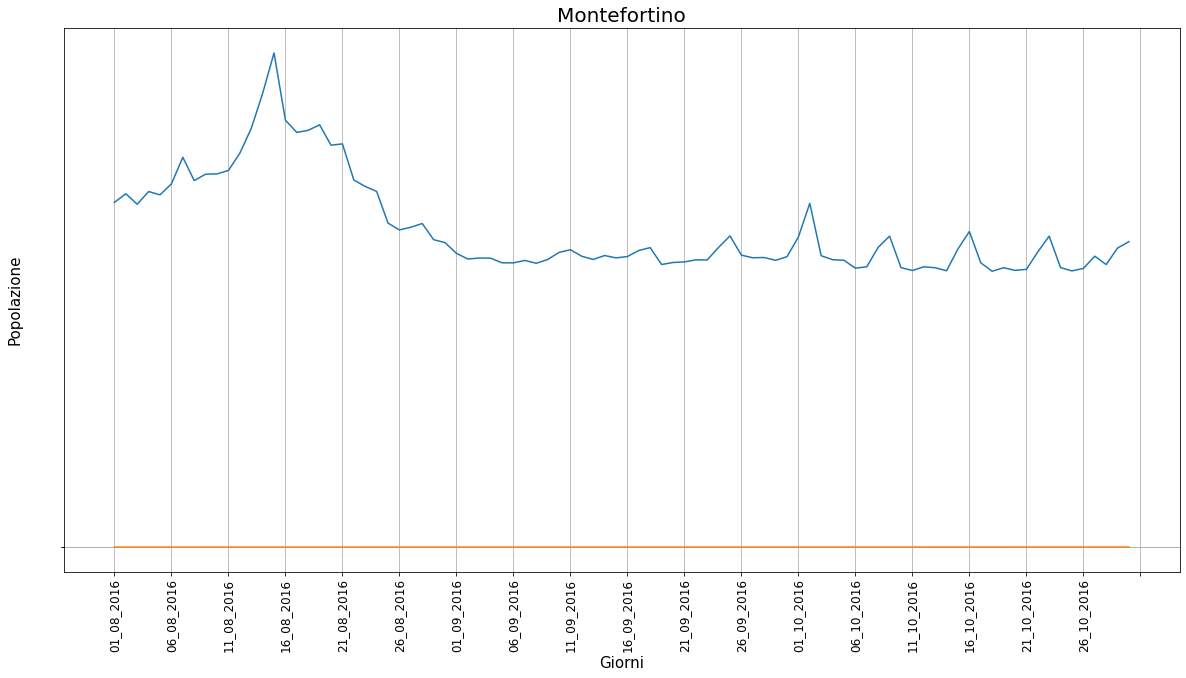

BilancioDemografico-SingolaArea-Comune_044038-Montegallo.csv: (['01_08_2016', '30_10_2016'], ['517', '517'])


<Figure size 432x288 with 0 Axes>

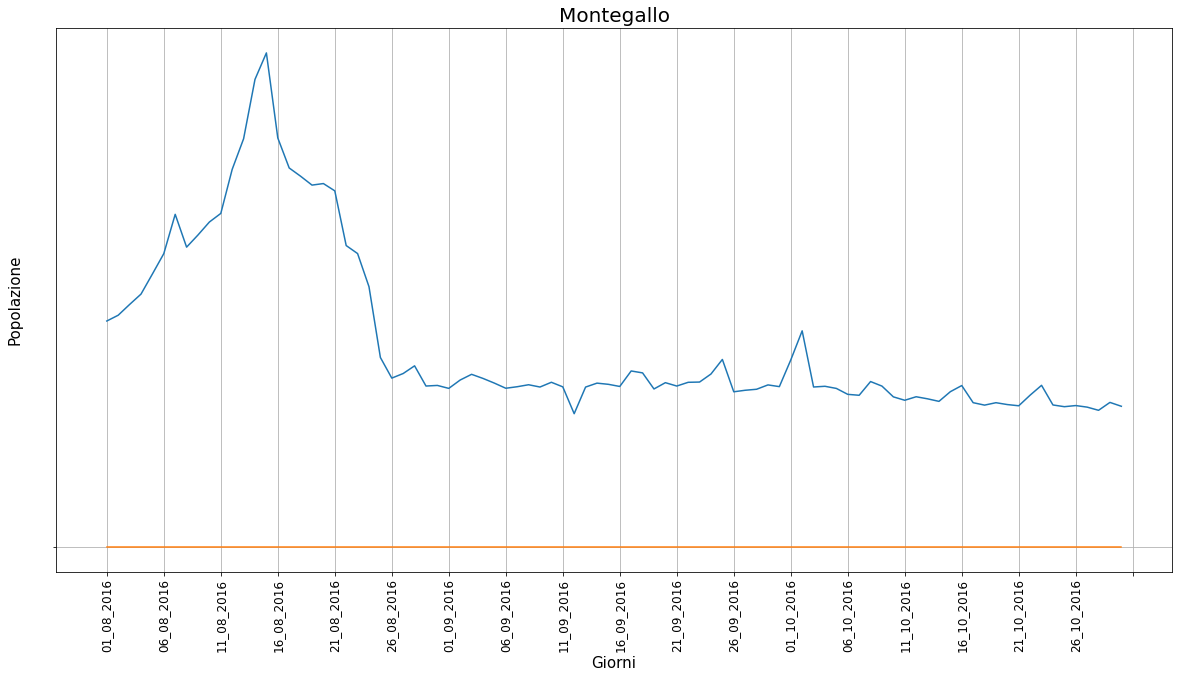

<Figure size 432x288 with 0 Axes>

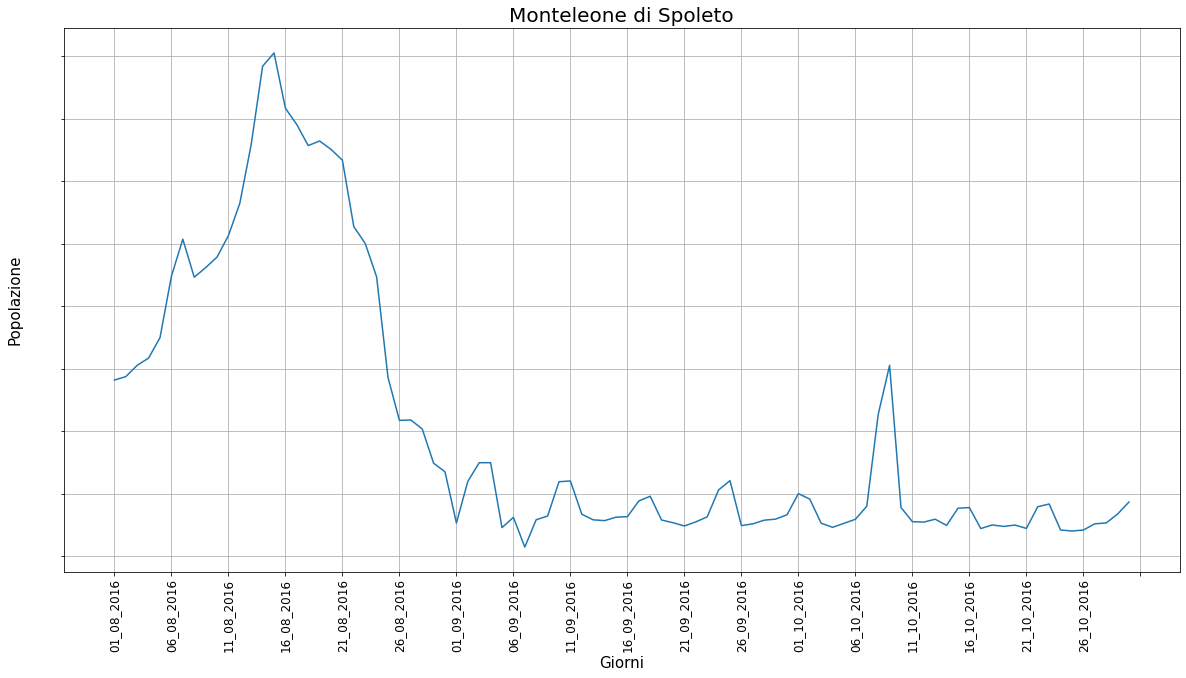

BilancioDemografico-SingolaArea-Comune_044044-Montemonaco.csv: (['01_08_2016', '30_10_2016'], ['616', '586'])


<Figure size 432x288 with 0 Axes>

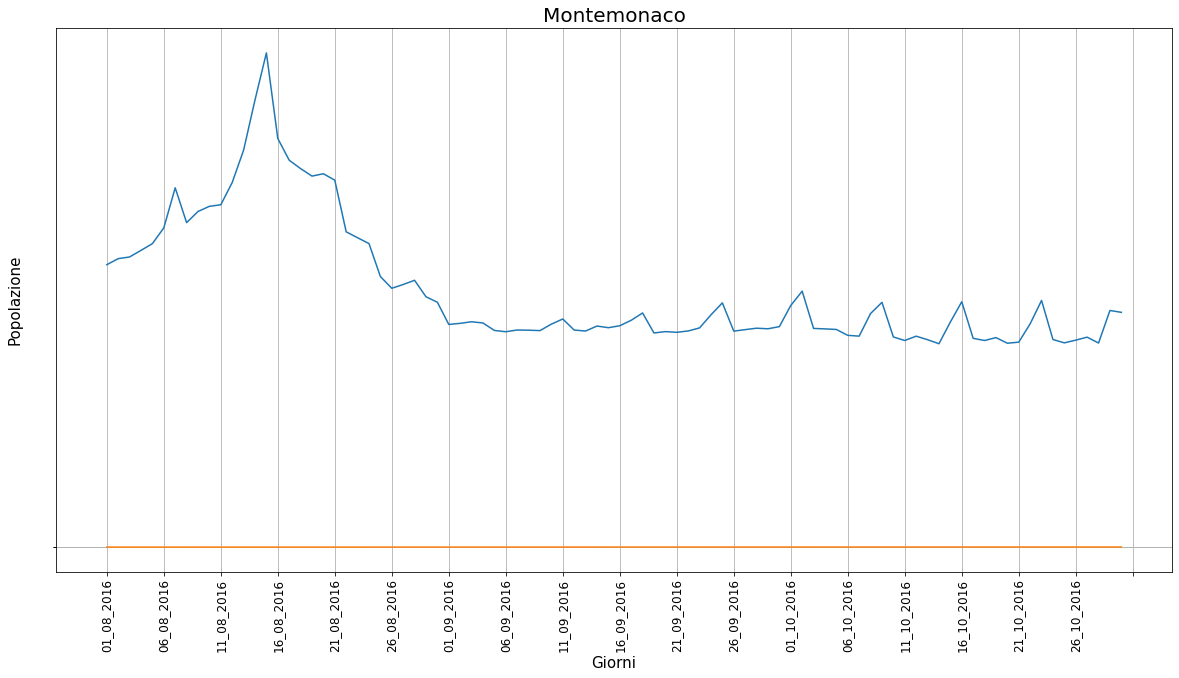

BilancioDemografico-SingolaArea-Comune_066056-Montereale.csv: (['01_08_2016', '30_10_2016'], ['2589', '2533'])


<Figure size 432x288 with 0 Axes>

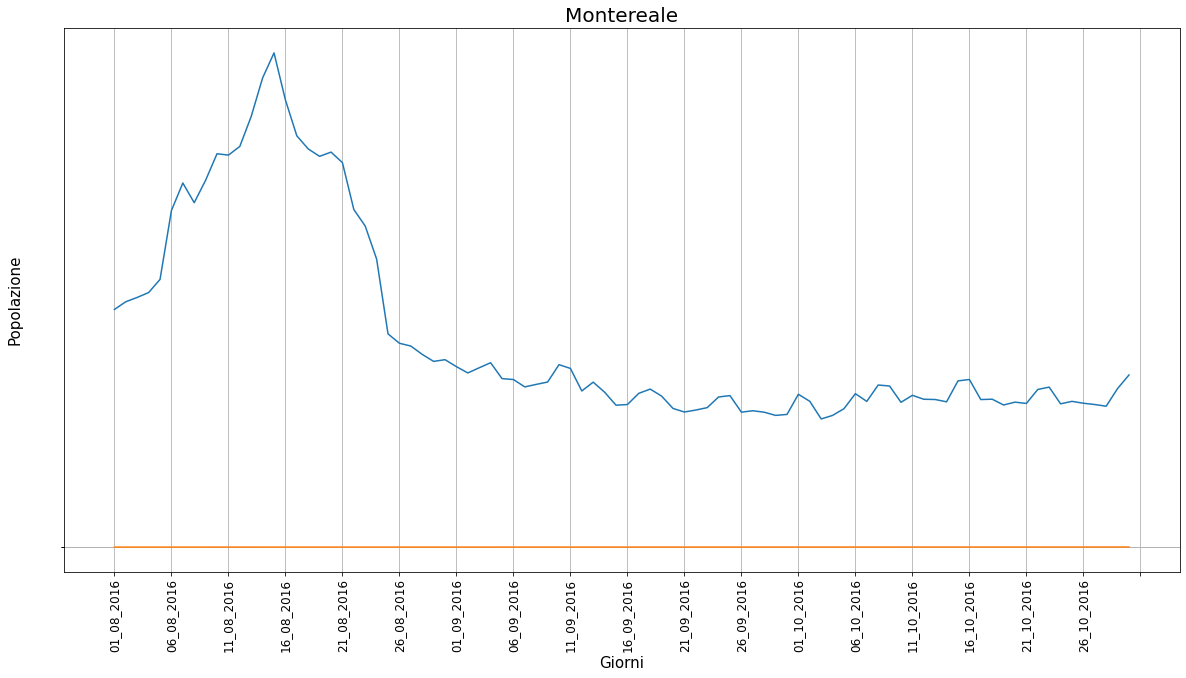

BilancioDemografico-SingolaArea-Comune_054035-Norcia.csv: (['01_08_2016', '30_10_2016'], ['4950', '4972'])


<Figure size 432x288 with 0 Axes>

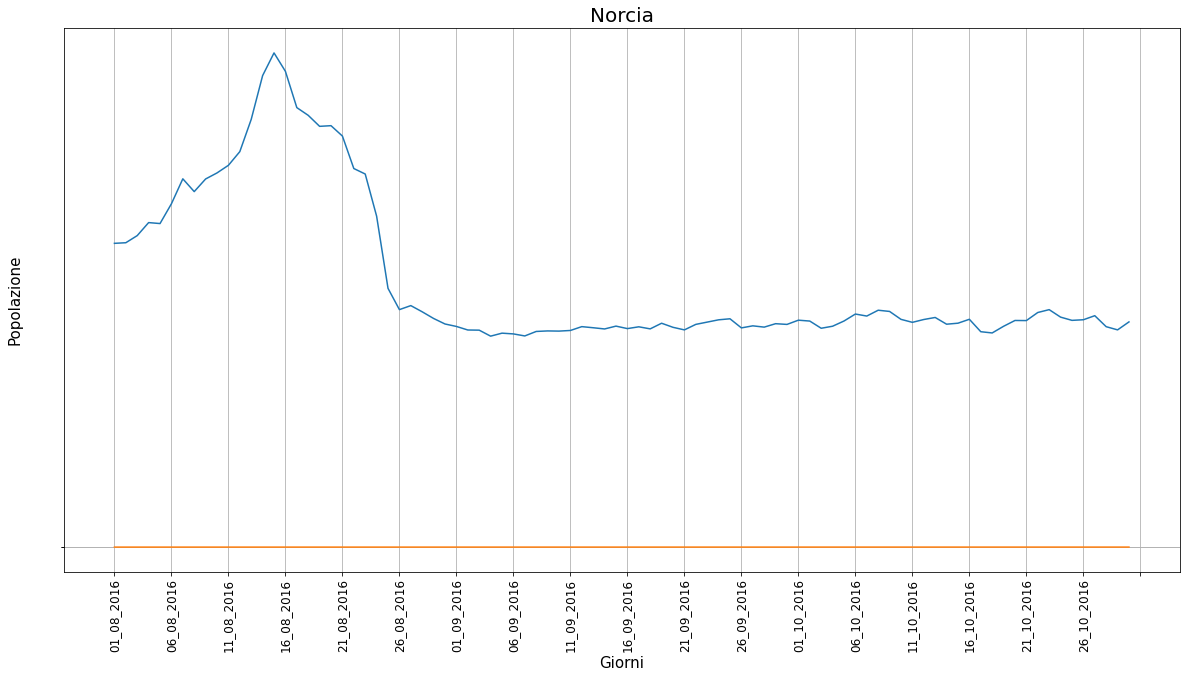

BilancioDemografico-SingolaArea-Comune_054043-Preci.csv: (['01_08_2016', '30_10_2016'], ['715', '709'])


<Figure size 432x288 with 0 Axes>

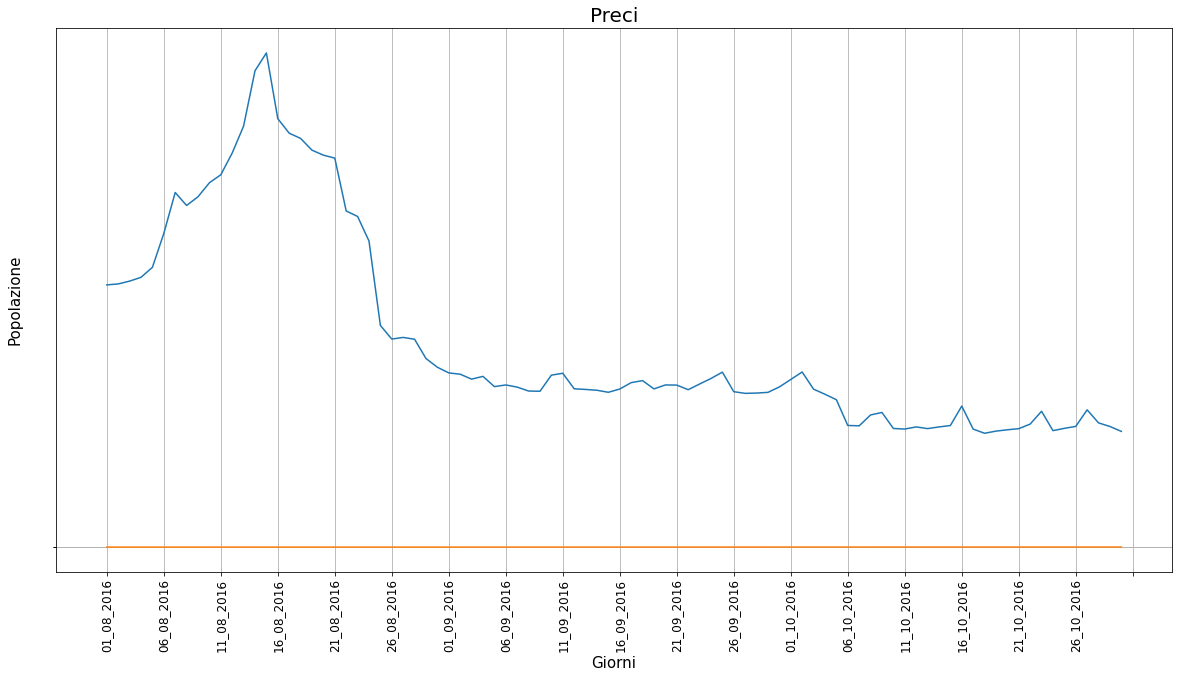

<Figure size 432x288 with 0 Axes>

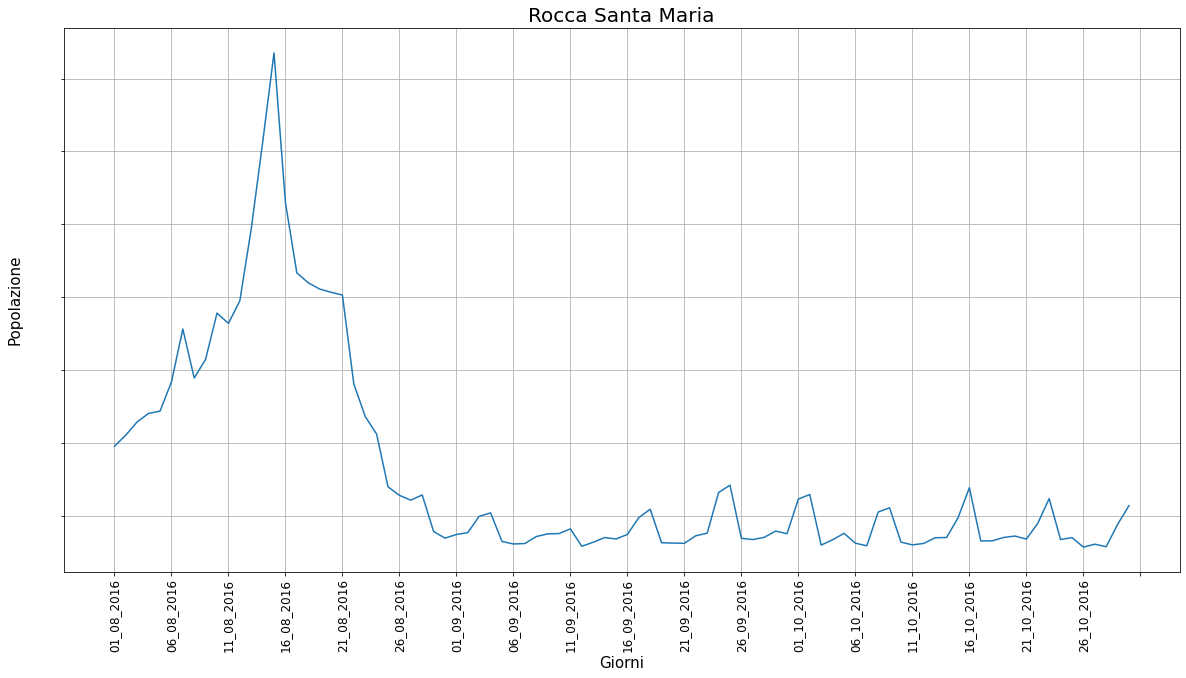

<Figure size 432x288 with 0 Axes>

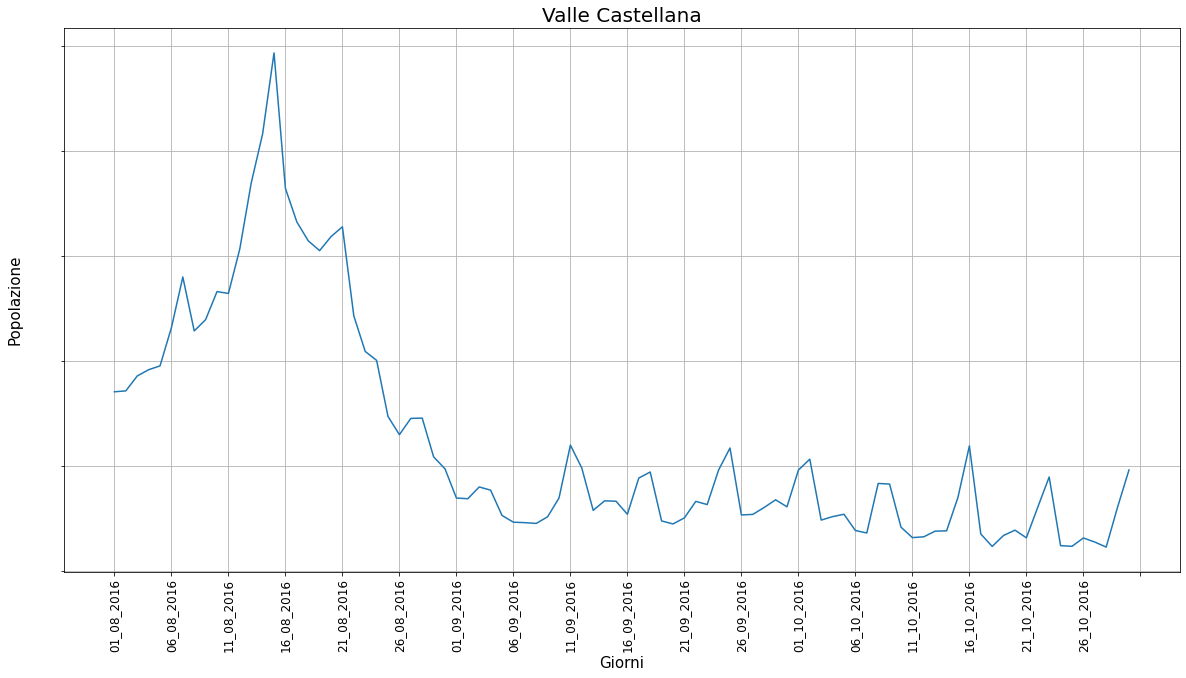

In [6]:
selini = f'D:/Università/Tirocinio/Analisi Dati/Selini/istat/BilancioDemografico-SingolaArea-Comuni_Ancona'
for i in gravi.Comune:
    plt.clf()
    plt.figure(figsize=[20, 10])
    plt.title(i, fontsize=20)
    plt.plot(se.loc[se.Comune == i].columns[2:], se.loc[se.Comune == i].iloc[0, 2:]*3/10, label=f'{i}')
    # plt.vlines('24_08', ymin=-50000, ymax=40000, colors='red')
    plt.xlabel('Giorni', fontsize=15)
    plt.xticks(np.arange(0, len(se.columns[2:]) + 1, 5), fontsize=12, rotation='vertical')
    #


    plt.ylabel('Popolazione', fontsize=15)
    plt.grid()



    for h in Files:
        if i in h:
            xpunti = [se.columns[2], se.columns[-1]]
            ypunti = [pd.read_csv(f'{selini}/{h}', sep=';', skiprows=[0, 1, 2, 3]).iloc[15, 1], pd.read_csv(f'{selini}/{h}',sep= ';', skiprows=[0,1,2,3]).iloc[15,9]]
            print(f'{h}: {xpunti, ypunti}')

            plt.plot(xpunti, ypunti)
            break
    plt.yticks( fontsize=12, color ='w')
    plt.show()

 # [pd.read_csv(f'{selini}/{h}', sep=';', skiprows=[0, 1, 2, 3]).iloc[15,1], pd.read_csv(f'{selini}/{h}', sep=';', skiprows=[0, 1, 2, 3]).iloc[15,9]]





Per ogni comune grave

KeyError: 0

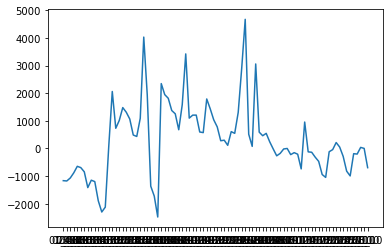

In [2]:
gravi = df.loc[df.Terremotata == 2]
# gravi.drop(columns = ['Comune', 'Terremotata'], inplace = True)
for i in range(len(gravi)):
    plt.clf()
    plt.plot(gravi.columns[2:], gravi.iloc[i,2:])
    plt.plot('24_08', gravi['24_08'][i], marker='o')
    plt.xlabel('Giorni')
    plt.ylabel('Popolazione')
    plt.title(gravi.Comune[i])
    plt.xticks(np.arange(0, len(gravi.columns[2:]) + 1, 5), fontsize = 8, rotation = 'vertical')
    plt.yticks(fontsize=8)
    plt.grid()
    plt.show()

comuni percentuale

<Figure size 432x288 with 0 Axes>

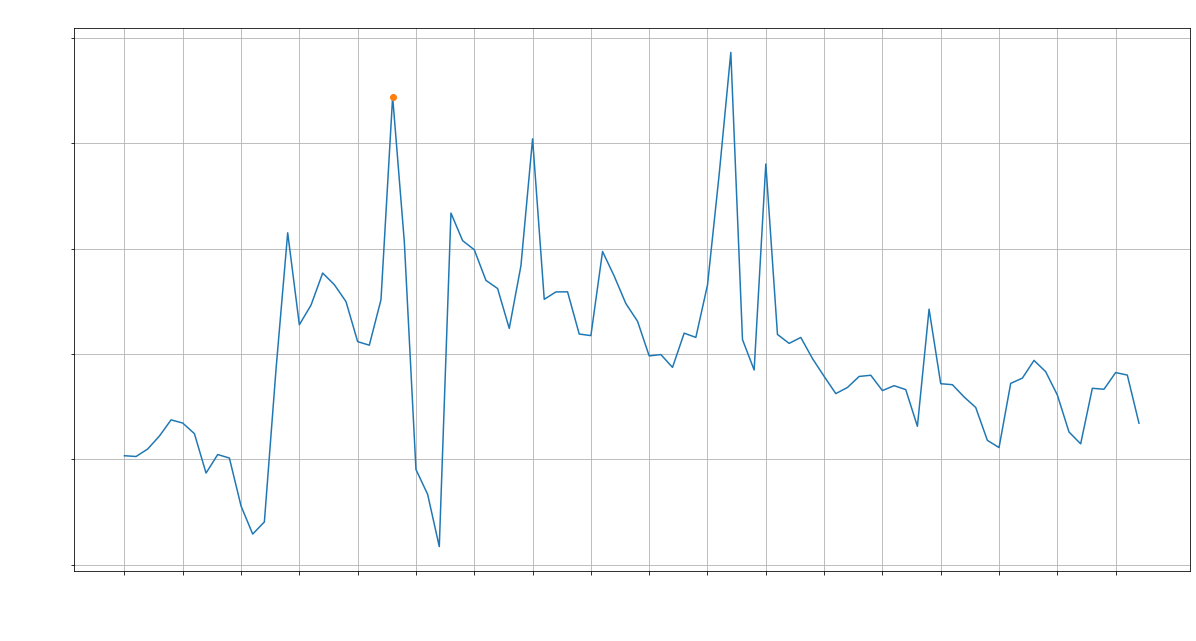

<Figure size 432x288 with 0 Axes>

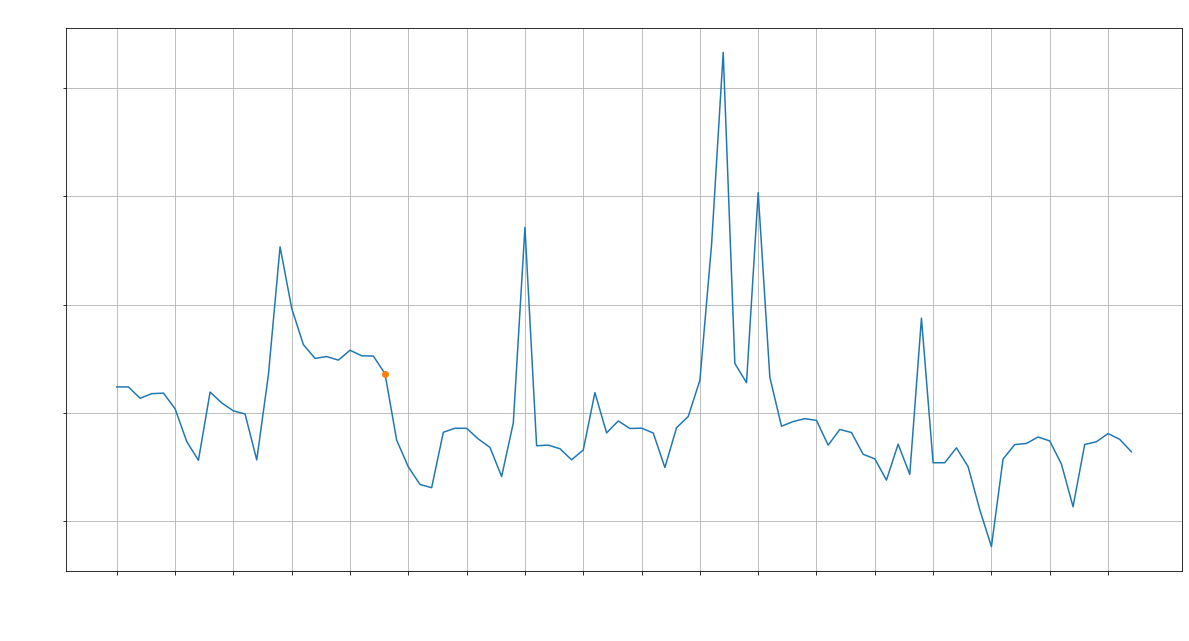

<Figure size 432x288 with 0 Axes>

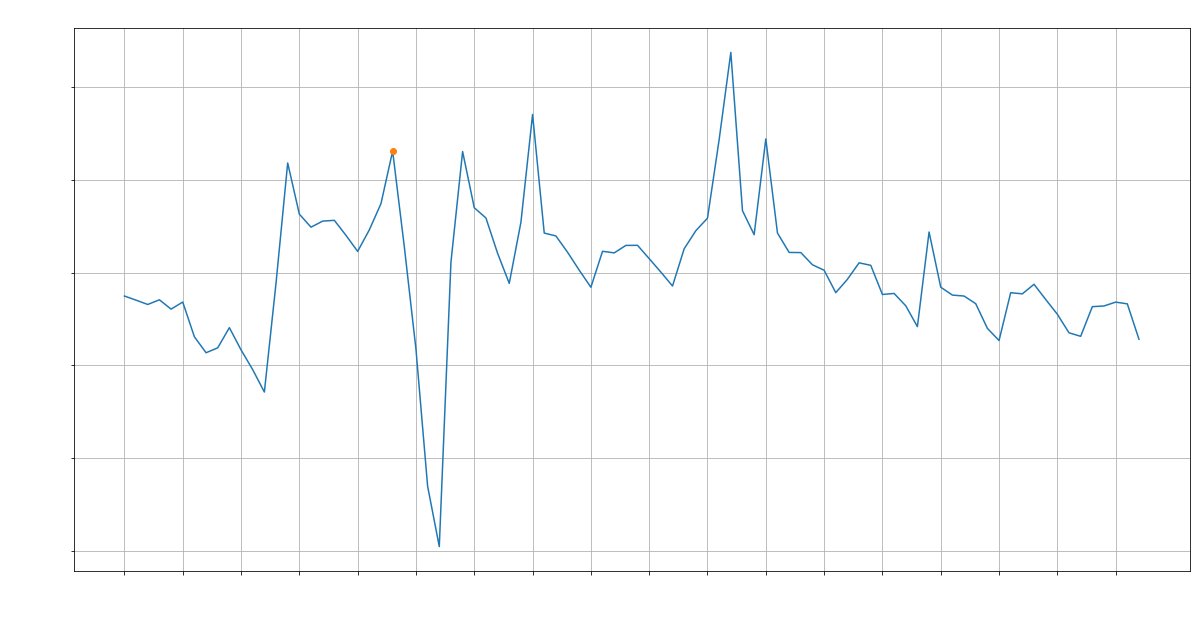

<Figure size 432x288 with 0 Axes>

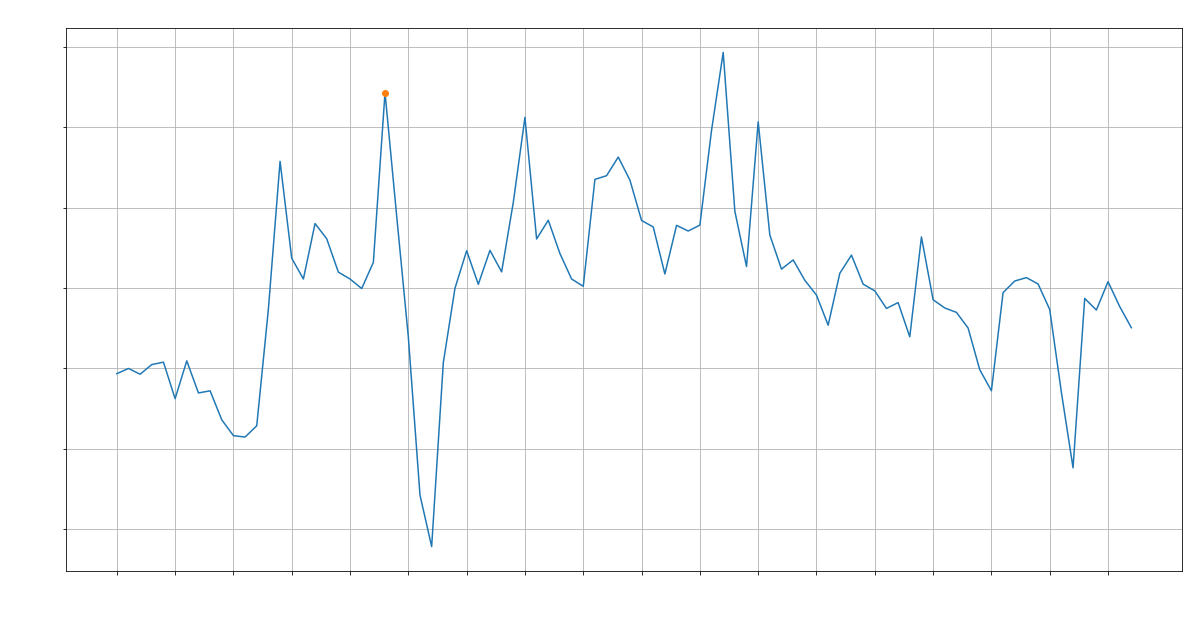

<Figure size 432x288 with 0 Axes>

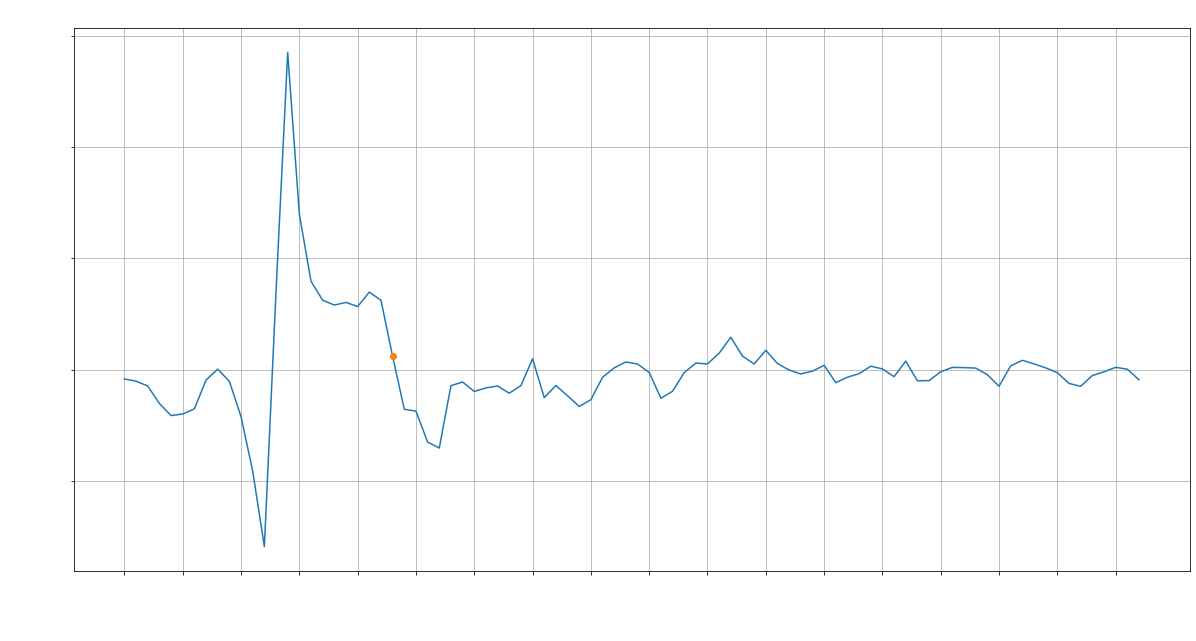

<Figure size 432x288 with 0 Axes>

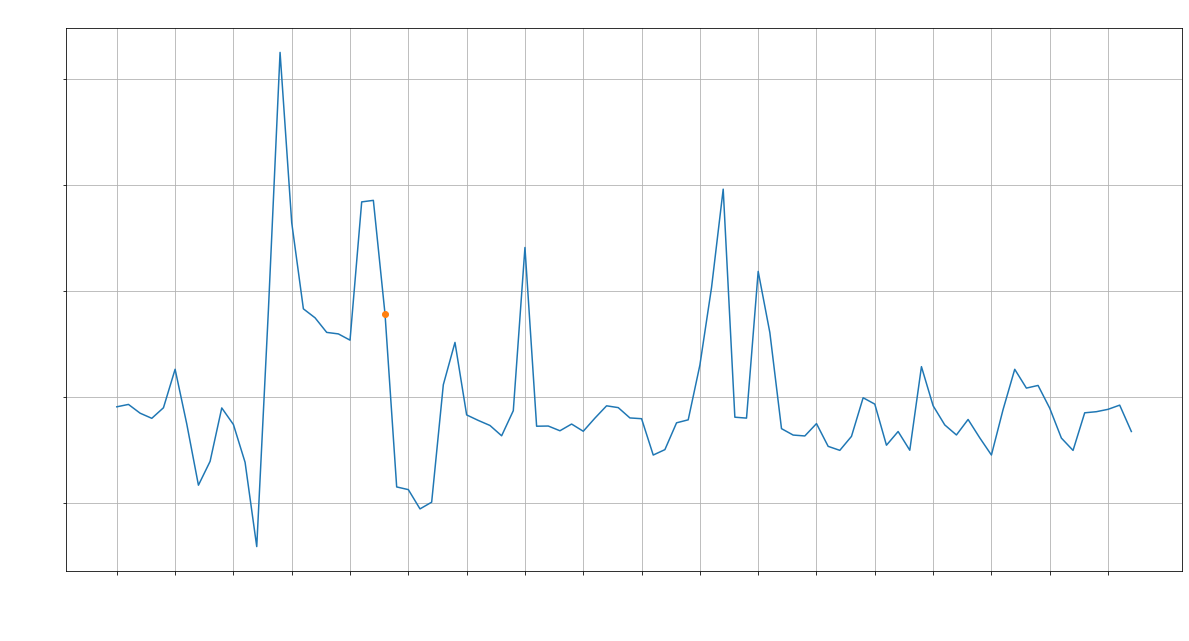

<Figure size 432x288 with 0 Axes>

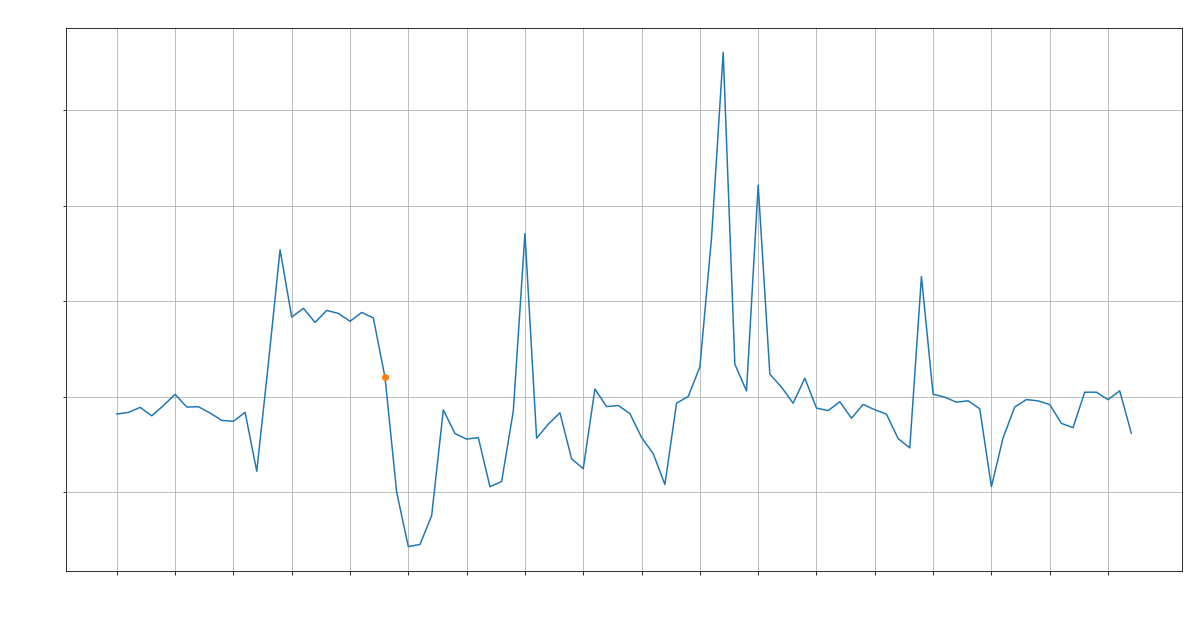

<Figure size 432x288 with 0 Axes>

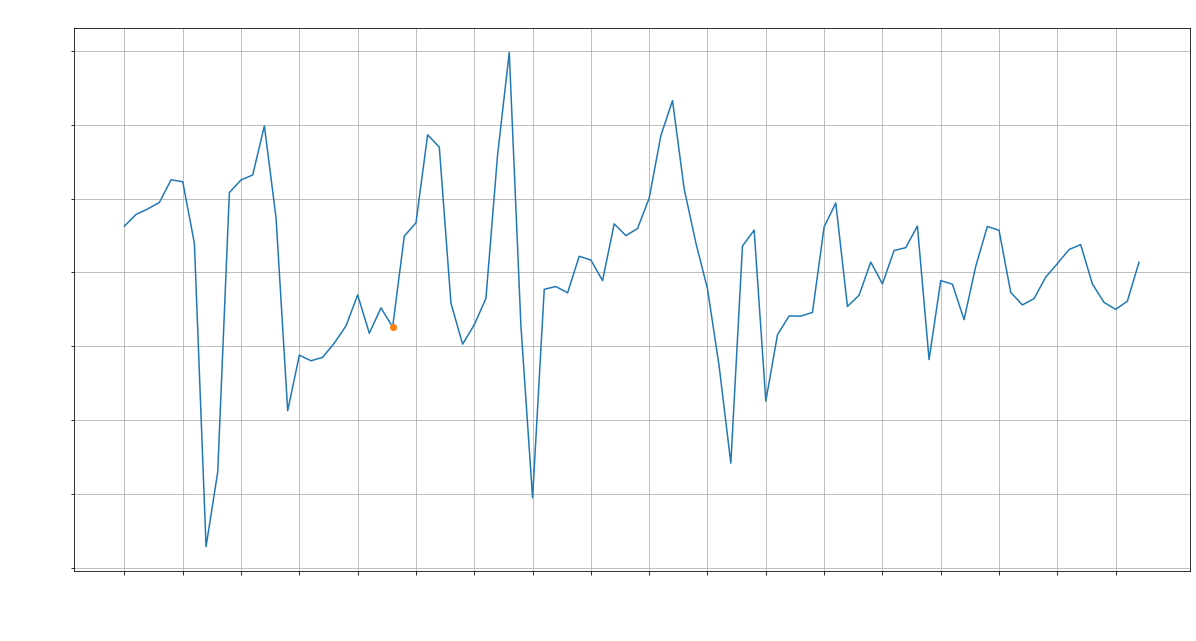

<Figure size 432x288 with 0 Axes>

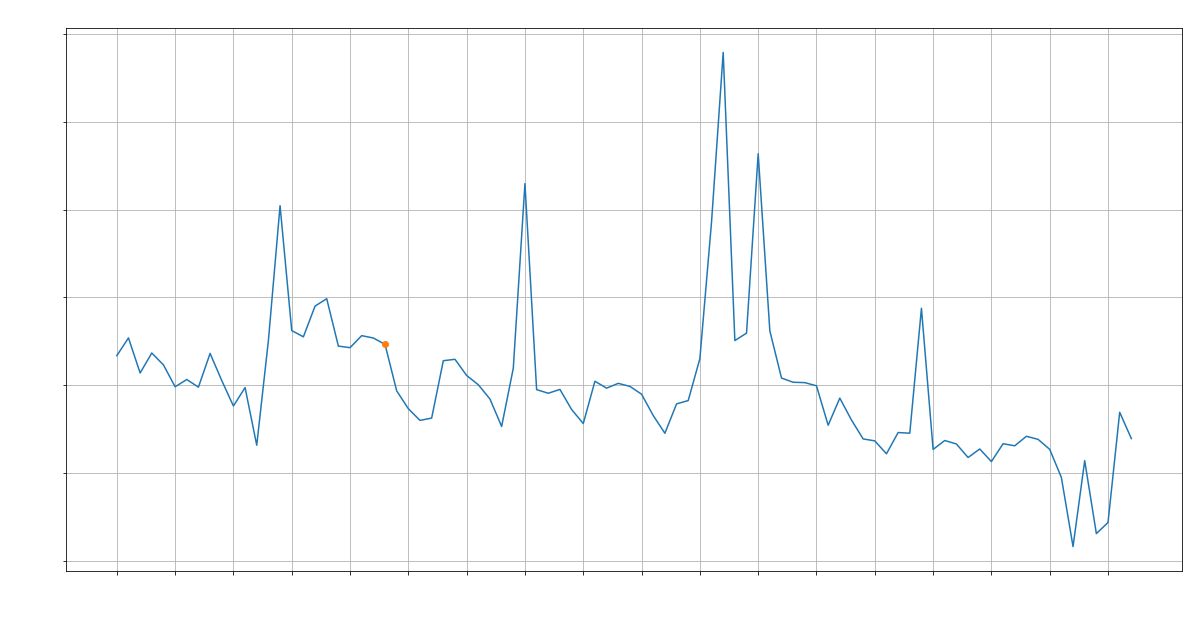

<Figure size 432x288 with 0 Axes>

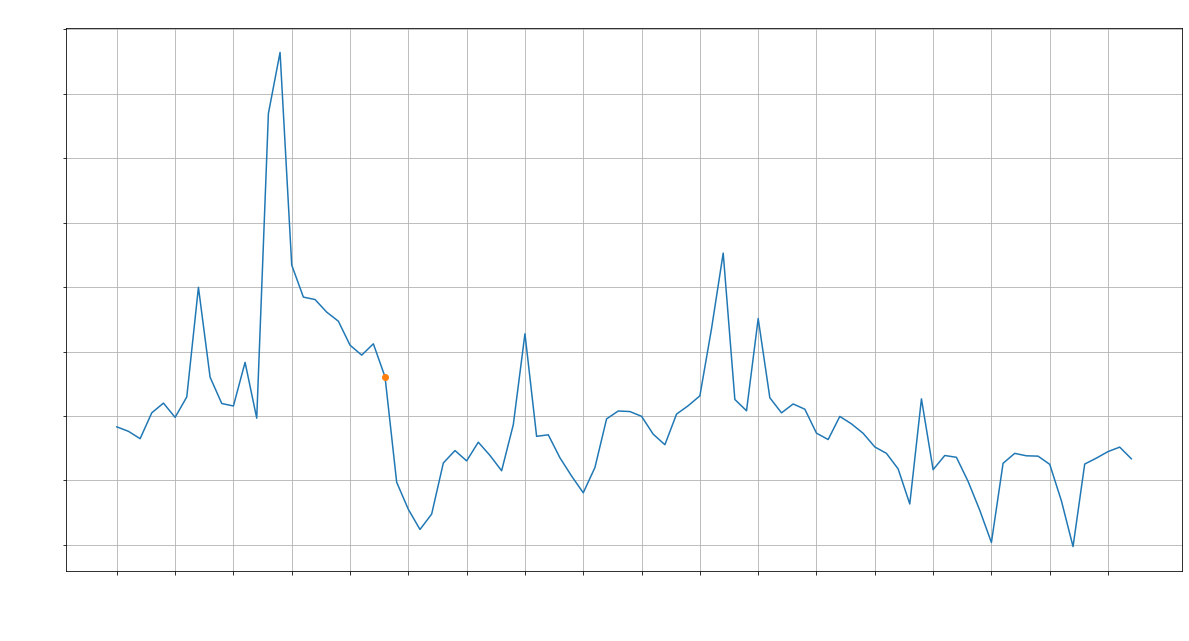

<Figure size 432x288 with 0 Axes>

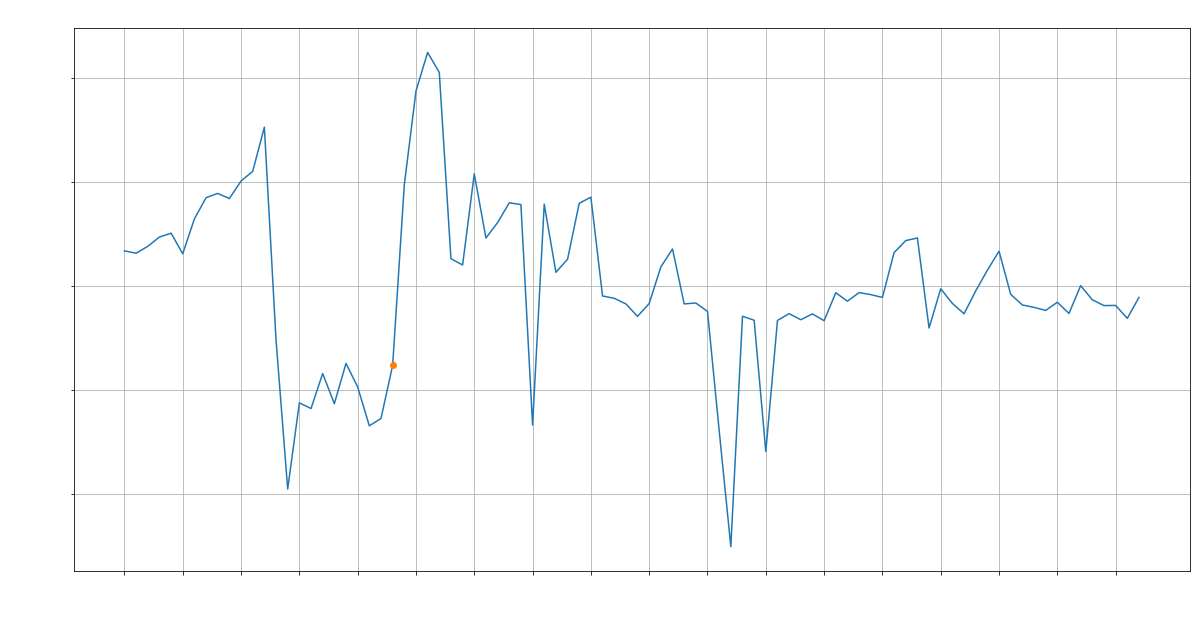

<Figure size 432x288 with 0 Axes>

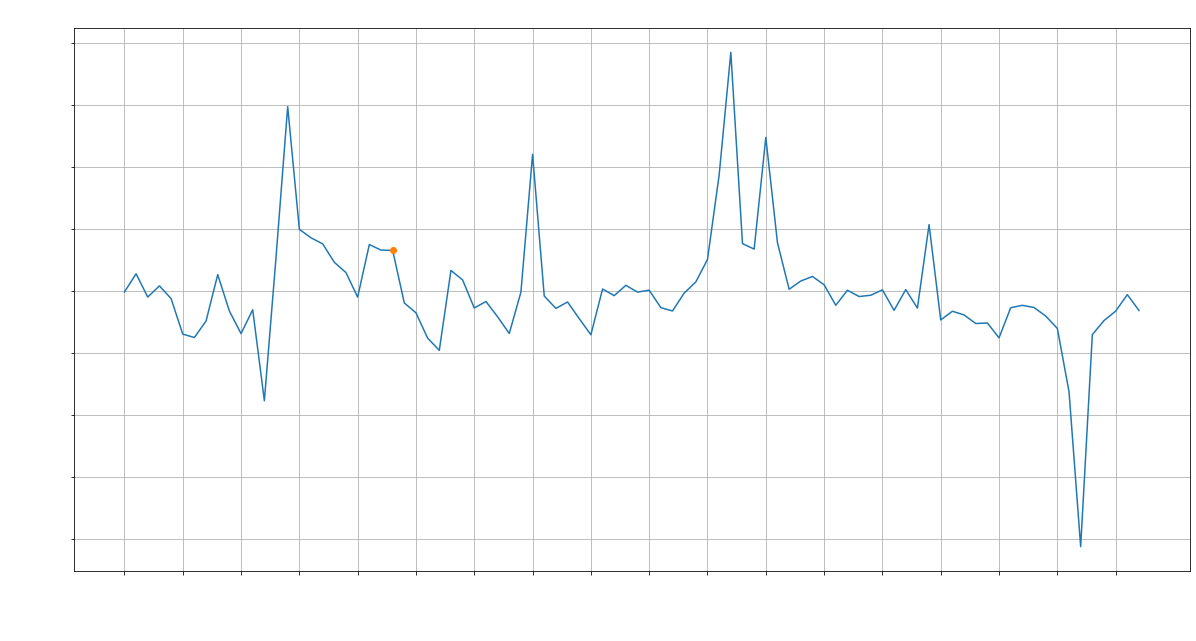

<Figure size 432x288 with 0 Axes>

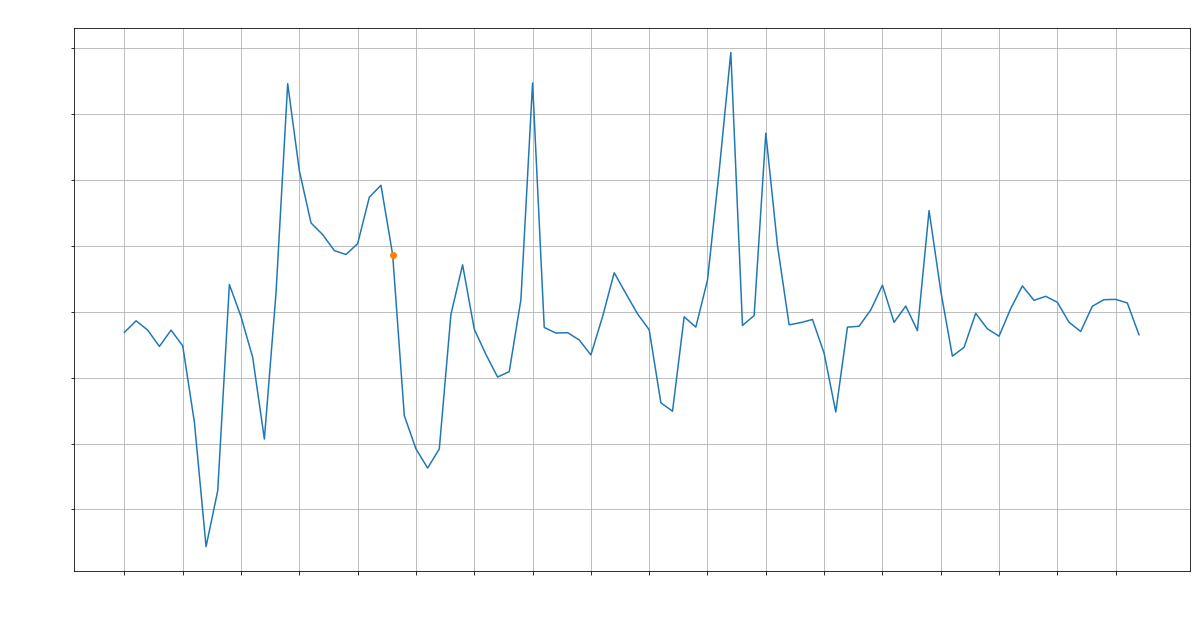

<Figure size 432x288 with 0 Axes>

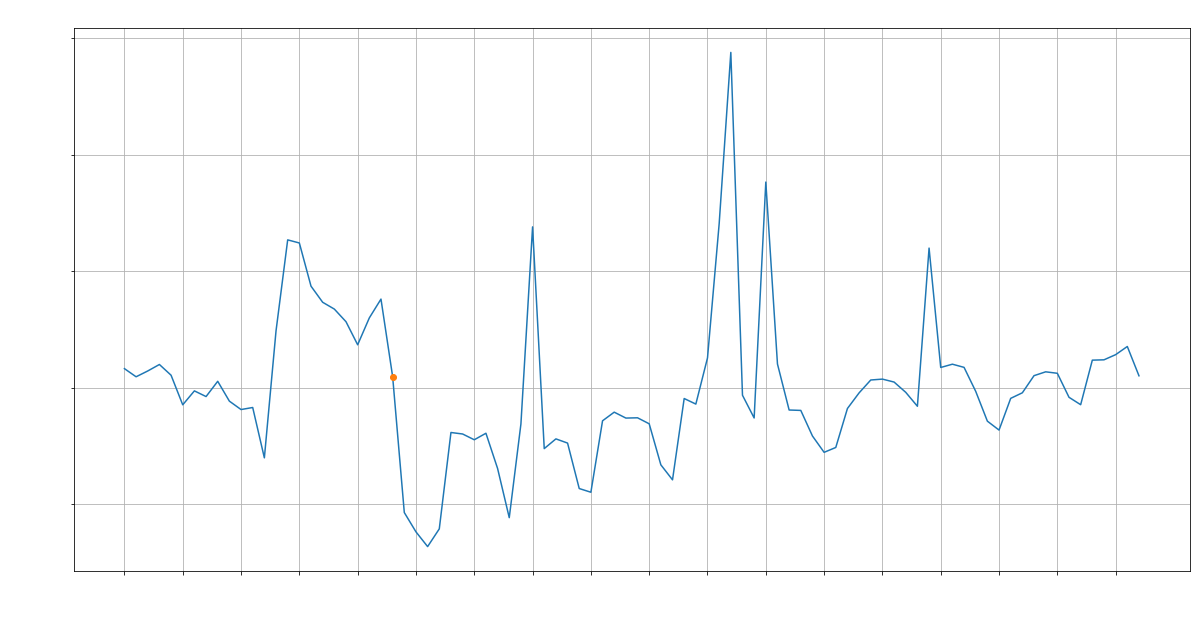

<Figure size 432x288 with 0 Axes>

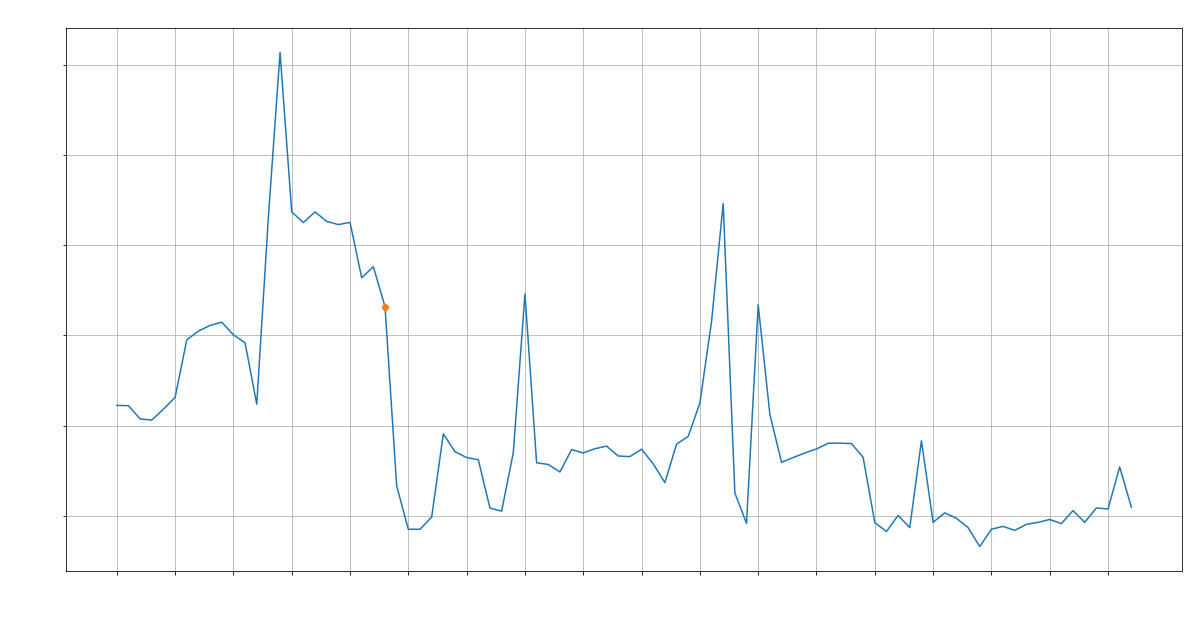

<Figure size 432x288 with 0 Axes>

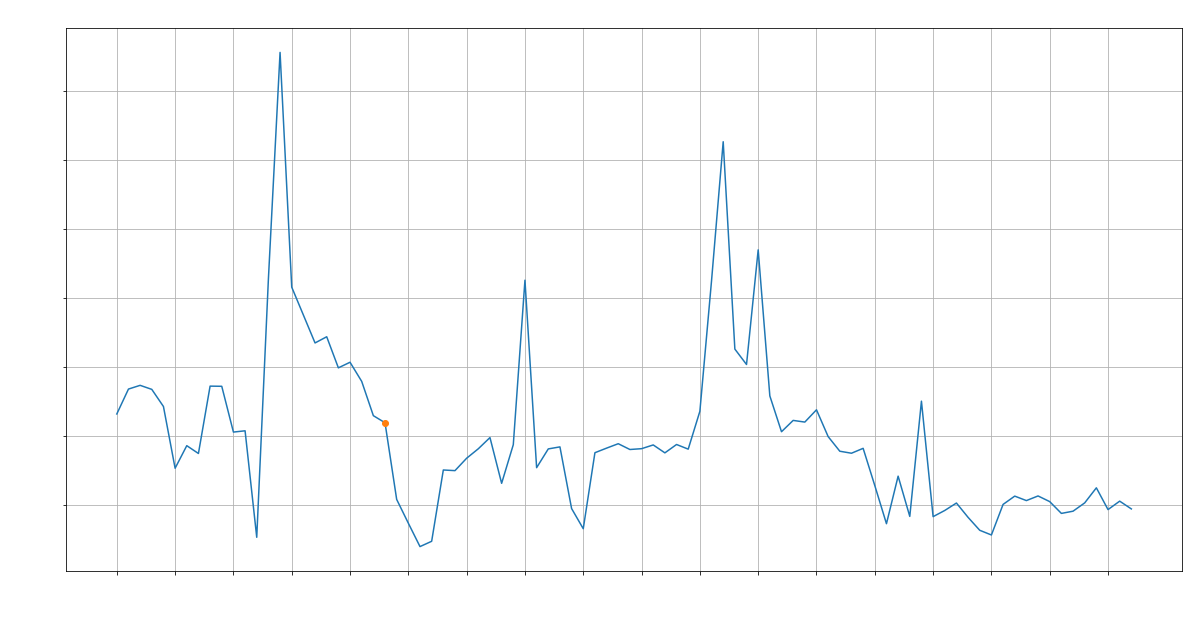

<Figure size 432x288 with 0 Axes>

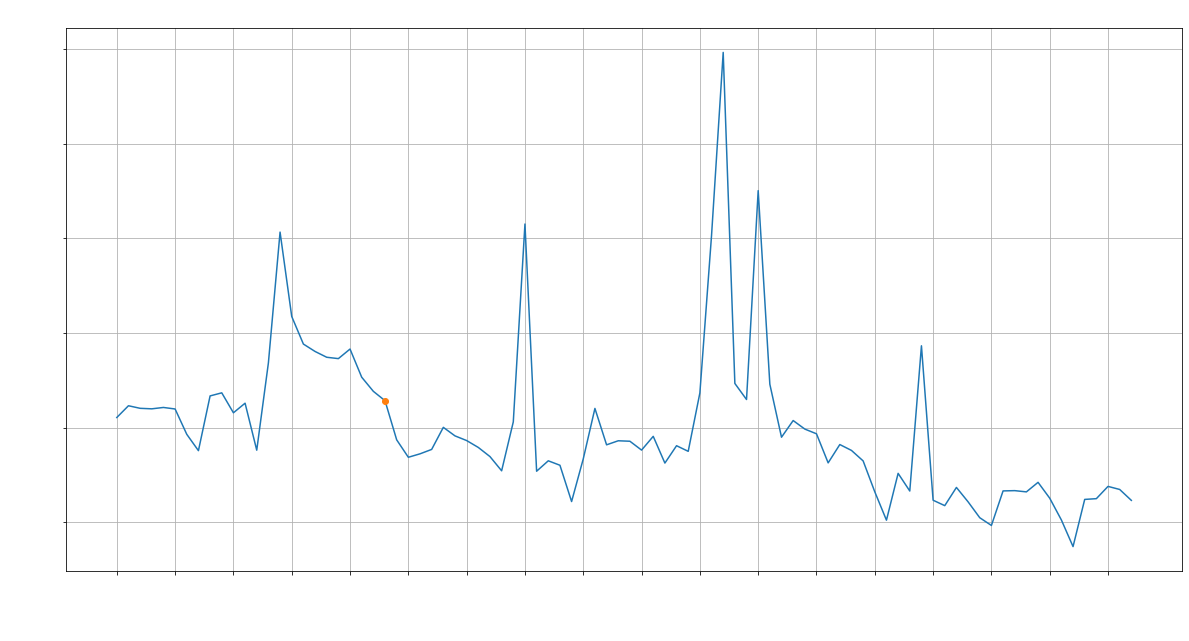

In [15]:
perc = gravi.copy()
medie = perc.iloc[:,2:].mean(axis=1)
for i in range(2,len(perc.columns)):
    perc.iloc[:,i]= (perc.iloc[:, i]-medie)*100/medie

for i in range(len(perc)):
    plt.clf()
    plt.figure(figsize=[20, 10])
    plt.plot(perc.columns[2:], perc.iloc[i, 2:])
    plt.plot('24_08', perc['24_08'][i], marker='o')


    plt.grid()
    plt.xlabel('Giorni', color='w', fontsize=15)
    plt.ylabel('Popolazione', color='w', fontsize=15)
    plt.title(f'{perc.index[i]}, media: {medie[i]}', color='w', fontsize=20)
    plt.xticks(np.arange(0, len(gravi.columns[2:]) + 1, 5), fontsize=12, rotation='vertical', color='w')
    plt.yticks(fontsize=12, color='w')
    plt.show()

medie

<Figure size 432x288 with 0 Axes>

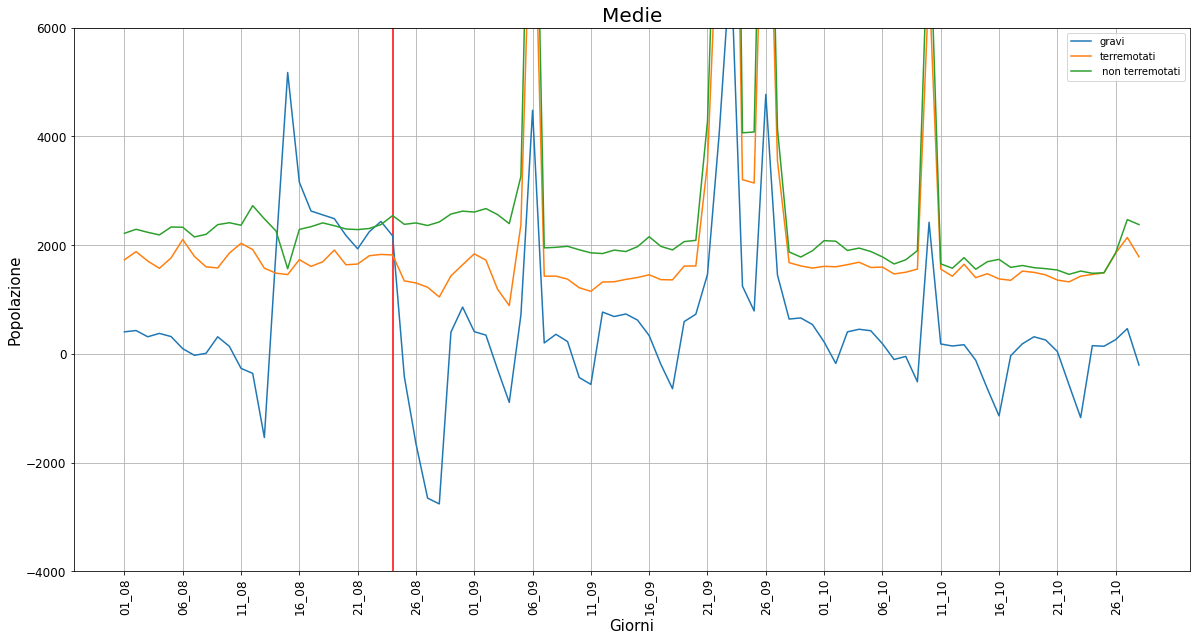

In [7]:
t = df.loc[df.Terremotata == 1]
t.set_index(t.Comune, inplace=True)
nt = df.loc[df.Terremotata != 1]
nt = nt.loc[nt.Terremotata != 2]
nt.set_index(nt.Comune, inplace=True)

media = gravi.drop(columns=['Comune', 'Terremotata'])
plt.clf()
plt.figure(figsize= [20,10])
plt.plot(gravi.columns[2:], media.mean(axis=0), label = 'gravi', )
plt.plot(gravi.columns[2:], t.iloc[:,2:].mean(axis = 0), label = 'terremotati')
plt.plot(gravi.columns[2:], nt.iloc[:, 2:].mean(axis=0), label=' non terremotati', )
plt.vlines('24_08', ymin= -4000, ymax= 6000, colors='red')
plt.ylim([-4000, 6000])
plt.xlabel('Giorni', fontsize=15)
plt.ylabel('Popolazione', fontsize=15)
plt.title('Medie', fontsize = 20)
plt.xticks(np.arange(0, len(gravi.columns[2:]) + 1, 5), fontsize=12, rotation='vertical')
plt.yticks(fontsize=12)
plt.grid()
plt.legend()
# plt.savefig('Grafici/medie.jpg')
plt.show()

Ultima call

<Figure size 432x288 with 0 Axes>

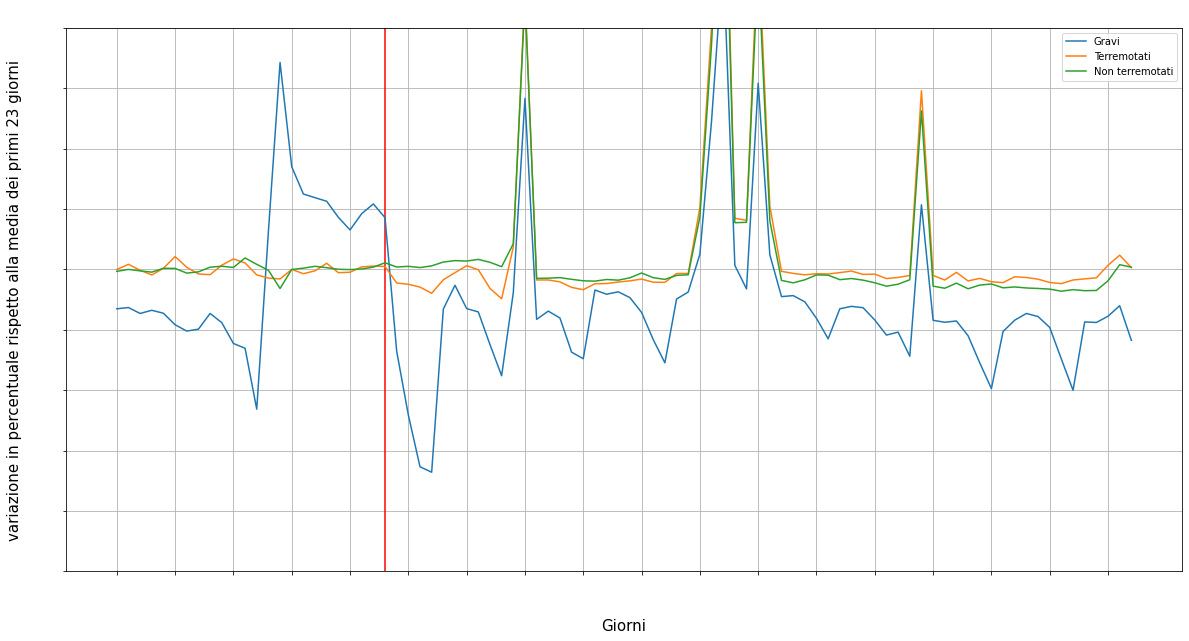

In [9]:
gravi = df.loc[df.Terremotata == 2]
seriegrave = gravi.iloc[:, 2:].mean()
mediag = seriegrave[:23].mean()

nt = df.loc[df.Terremotata != 1]
nt = nt.loc[nt.Terremotata != 2]
nt.set_index(nt.Comune, inplace=True)
nt = nt.iloc[:, 2:].mean()
mediant = nt[:23].mean()

t = df.loc[df.Terremotata == 1]
t = t.iloc[:, 2:].mean()
mediat = t[:23].mean()

plt.clf()
plt.figure(figsize=[20, 10])
plt.plot(t.index, (seriegrave -mediag) * 100 / mediag, label='Gravi')
plt.plot(t.index,( t -mediat)* 100 / mediat, label='Terremotati')
plt.plot(t.index, (nt-mediant) * 100 / mediant, label='Non terremotati')
plt.vlines('24_08', ymin=-500, ymax=400, colors='red')
plt.ylim([-500, 400])
plt.xlabel('Giorni', fontsize=15)
plt.ylabel('variazione in percentuale rispetto alla media dei primi 23 giorni', fontsize=15)
plt.title('Medie rispetto ai primi 23 giorni', fontsize=20, color='w')
plt.xticks(np.arange(0, len(gravi.columns[2:]) + 1, 5), fontsize=12, rotation='vertical', color='w')
plt.yticks(fontsize=12, color = 'w')
plt.grid()
plt.legend()
# plt.savefig('Grafici/medie rispetto ai primi 23 giorni.jpg')
plt.show()

01_08_2016    23798.770833
02_08_2016     23752.78125
03_08_2016    24170.947917
04_08_2016    25092.666667
05_08_2016    26495.895833
                  ...     
26_10_2016    10306.958333
27_10_2016    10257.572917
28_10_2016     9744.739583
29_10_2016    10476.885417
30_10_2016    10159.770833
Name: 17, Length: 90, dtype: object